## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots and global variables

In [4]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [5]:
with open("rdm_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [6]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('RDM_cd', 'RDM_ndm', 'ANN-RDM_l_FC', 'ANN-RD…

In [ ]:
model_config

{'model_name': 'ANN-RDM_full_FC',
 'stan_file': 'ANN-RDM/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-RDM_full_FC',
 'transf_params': ['transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_threshold_word',
  'transf_mu_threshold_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_k_1',
  'transf_mu_k_2']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [8]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =['string', 'freq',  'label', 'zipf',
                                    'category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [9]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + 'LDT_data_test.csv',
                             header=None,
                             names=['accuracy', 'rt', 'string', 'response',
                                    'participant', 'minRT', 'participant_id'])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [10]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.502,stunt,1,0.362,1,1.0,3.963932,HF,1.000000,2.033012e-07
1,1,0.577,elastic,1,0.362,1,1.0,3.024228,HF,0.999996,4.324682e-06
2,1,0.518,now,1,0.362,1,1.0,6.504911,HF,0.999970,3.024556e-05
3,0,0.543,vaitresses,1,0.362,1,0.0,0.000000,NW,0.000069,9.999310e-01
4,1,0.556,sweetness,1,0.362,1,1.0,3.517143,HF,0.999996,4.047130e-06


## Stan Model and Estimation

Compiling stan model

In [ ]:
rdm_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path)

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [ ]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant_id'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

threshold_priors = [0, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'threshold_priors': threshold_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [ ]:
fit = rdm_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

## Loading Model

(In case model have been fitted before)

In [15]:
fit = cmdstanpy.from_csv(stan_output_dir)

21:19:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.4%)
	Chain 2 had 2 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [16]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: ./stan_results/ANN-RDM_full_FC/ANN-RDM_full_FC-20230311210100_1.csv, ./stan_results/ANN-RDM_full_FC/ANN-RDM_full_FC-20230311210100_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
4 of 1000 (0.40%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [17]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-755.214000,0.424608,6.805420,-766.998000,-754.958000,-744.458000,256.882,0.529555,1.004030
mu_g,-3.550400,0.020525,0.674490,-4.683320,-3.527120,-2.452550,1079.940,2.226260,0.998885
mu_m,-0.361099,0.017967,0.410010,-1.000250,-0.357742,0.380310,520.771,1.073560,1.005300
mu_threshold_word,1.167090,0.018483,0.384008,0.494492,1.214140,1.686630,431.660,0.889856,0.998542
mu_threshold_nonword,1.554320,0.017926,0.380037,0.827336,1.620910,2.041190,449.462,0.926553,1.013790
...,...,...,...,...,...,...,...,...,...
log_lik[1837],-3.259520,0.007815,0.267630,-3.731700,-3.240620,-2.843150,1172.670,2.417430,0.998593
log_lik[1838],-2.080260,0.004764,0.165428,-2.367050,-2.071290,-1.825940,1205.770,2.485670,0.998371
log_lik[1839],-3.059520,0.006030,0.220268,-3.431020,-3.054810,-2.695560,1334.390,2.750800,0.998683
log_lik[1840],-2.200580,0.005056,0.175248,-2.505820,-2.191510,-1.930380,1201.560,2.476980,0.998385


In [18]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
2


In [19]:
df.loc[df['R_hat']>1.01].to_csv('logs/'+model_config['model_name']+'_rhat_log.csv')

In [20]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
mu_threshold_nonword,1.55432,0.017926,0.380037,0.827336,1.62091,2.04119,449.4620,0.926553,1.01379
transf_mu_threshold_nonword,1.75749,0.013620,0.296260,1.190040,1.80133,2.16330,472.8883,0.974850,1.01272


In [21]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,1.655905,0.015773,0.338149,1.008688,1.711120,2.102245,461.175150,0.950701,1.013255
std,0.143663,0.003045,0.059239,0.256470,0.127576,0.086345,16.564896,0.034151,0.000757
min,1.554320,0.013620,0.296260,0.827336,1.620910,2.041190,449.462000,0.926553,1.012720
25%,1.605112,0.014696,0.317204,0.918012,1.666015,2.071718,455.318575,0.938627,1.012987
50%,1.655905,0.015773,0.338149,1.008688,1.711120,2.102245,461.175150,0.950701,1.013255
75%,1.706697,0.016849,0.359093,1.099364,1.756225,2.132772,467.031725,0.962776,1.013523
max,1.757490,0.017926,0.380037,1.190040,1.801330,2.163300,472.888300,0.974850,1.013790


## Check parameters

Parameters posterior plots

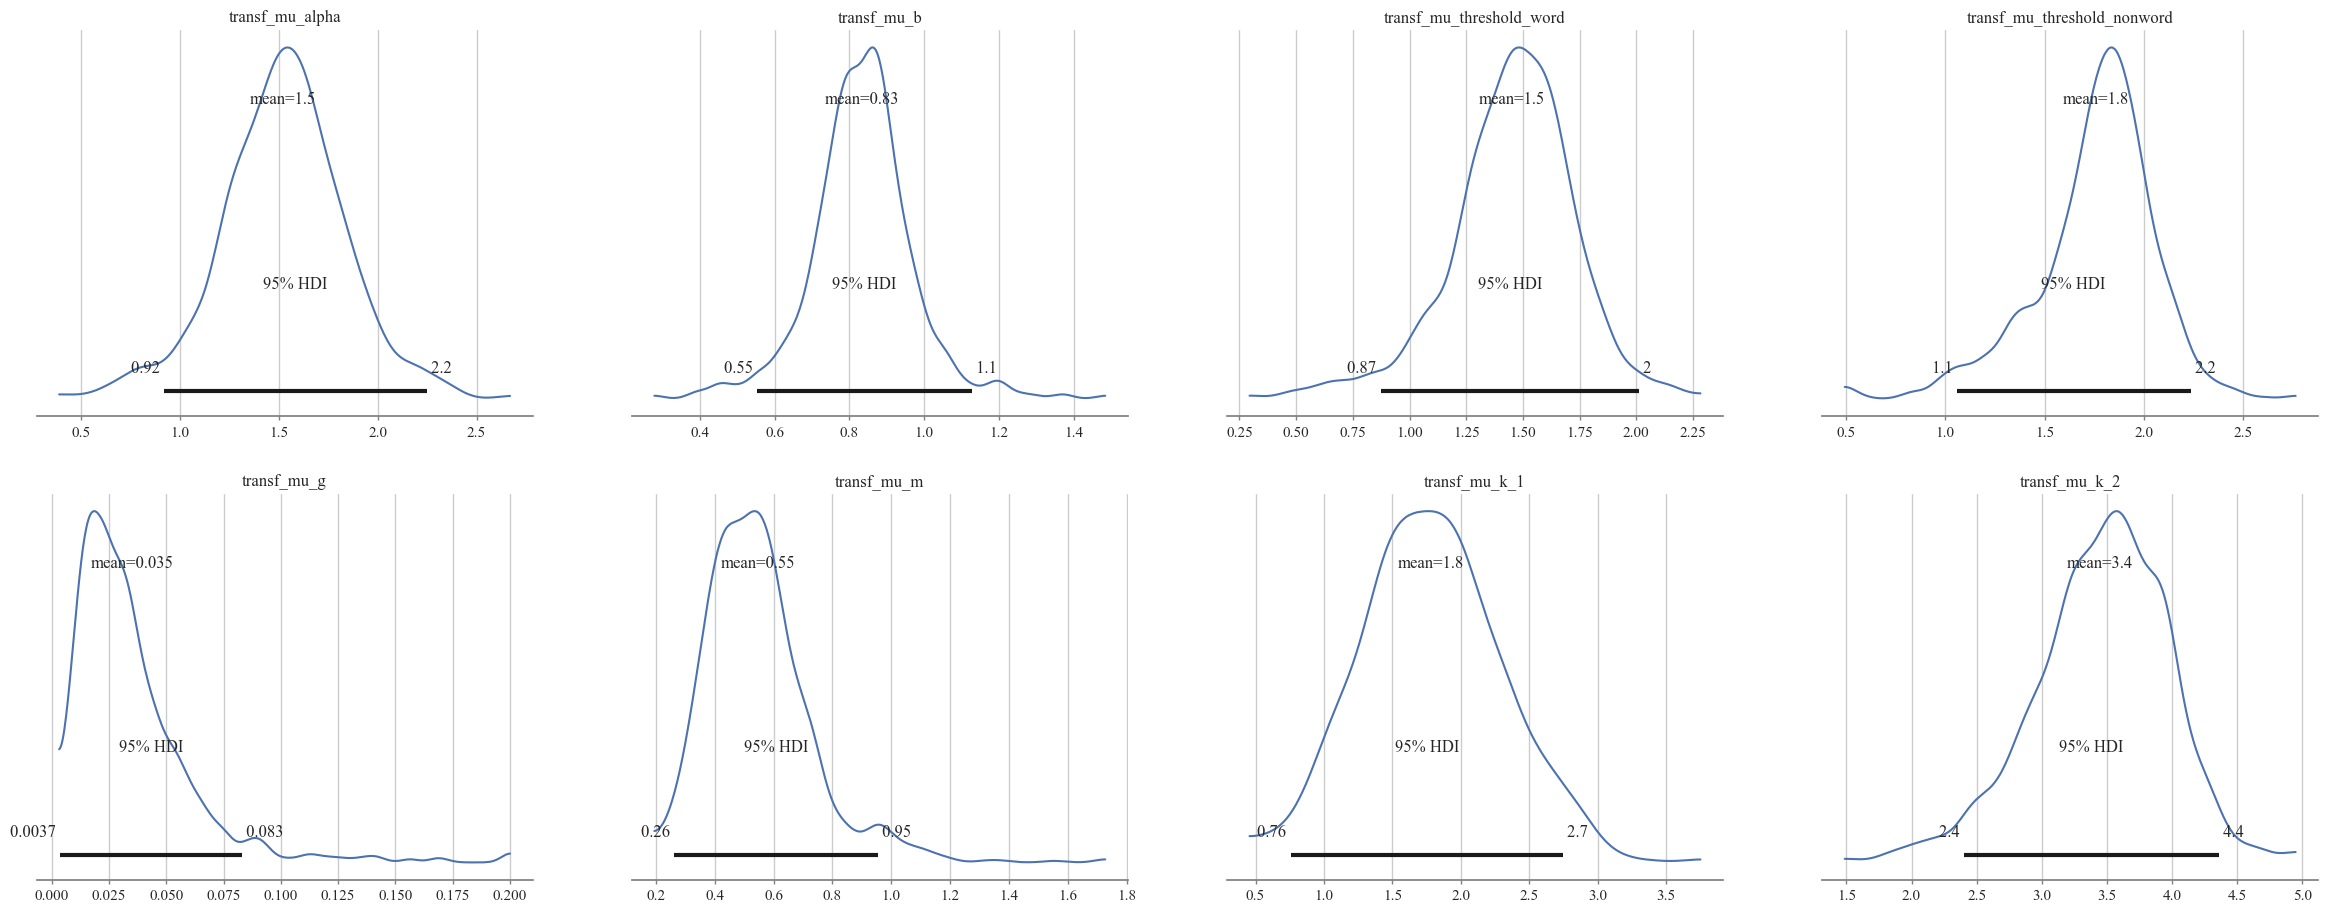

In [22]:
az.plot_posterior(fit, var_names=model_config['transf_params'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [23]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
if model_config['model_name'] != "RDM":
    threshold_t_word = fit.stan_variables()['threshold_t_word']
    threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
else:
    threshold_t = fit.stan_variables()['threshold_t']
ndt_t = fit.stan_variables()['ndt_t']

#### Models mean parameters in different conditions

In [24]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [25]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

HF words, word drift mean and std:
3.0842614066573817 0.09735298129618611
HF words, nonword drift mean and std:
1.2156965037827296 0.10330052125389866
LF words word drift mean and std:
2.2206788494918035 0.08781122797233962
LF words nonword drift mean and std:
1.2048572271762297 0.10684360942098843
NW words word drift mean and std:
0.5717793881172314 0.0686122850825174
NW words nonword drift mean and std:
2.6533450012032196 0.08180241121247665


In [26]:
if model_config['model_name'] != "RDM":
    HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
    HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
    LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
    LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
    NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
    NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]
else:
    HF_condition = threshold_t[:, behavioural_df['category']=="HF"]
    LF_condition = threshold_t[:, behavioural_df['category']=="LF"]
    NW_condition = threshold_t[:, behavioural_df['category']=="NW"]

In [27]:
if model_config['model_name'] != "RDM":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))
else:
    print('HF words, threshold mean and std:')
    print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
    print('LF words, threshold mean and std:')
    print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
    print('NW words, word threshold mean and std:')
    print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words, word threshold mean and std:
1.584388536874652 0.0641582817093794
HF words, nonword threshold mean and std:
1.9137127159888578 0.07468307028606215
LF words word threshold mean and std:
1.5932804125983602 0.06965141399490067
LF words nonword threshold mean and std:
1.9290787819262292 0.08023564266201803
NW words word threshold mean and std:
1.5969946578913472 0.0661097161011831
NW words nonword threshold mean and std:
1.9282963250704233 0.07734374979376024


In [28]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [29]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words ndt_t mean and std:
0.19578939766573814 0.012019343743873171
LF words ndt_t mean and std:
0.2065956417602459 0.013158662784824509
Non Words ndt_t mean and std:
0.20739607531187113 0.013465061059340715


## Calculating metrics

In [30]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [31]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -707.324298074054, 'p_waic': 38.44037669170815, 'waic': 1491.5293495315243, 'waic_se': 100.70245355845273}


## Simulating RDM with estimated parameters

In [32]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

In [33]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

Simulating RDM with estimated parameters

In [34]:
if model_config['model_name'] != "RDM":
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)
else:
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t, threshold_t, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [35]:
# Predicted Data
tmp1 = pd.DataFrame(pp_rt,
                    index=pd.Index(np.arange(1, len(pp_rt)+1), name='sample'),
                    columns=pd.MultiIndex.from_product((['rt'],
                                                        np.arange(pp_rt.shape[1])),
                                                        names=['variable', 'trial']))
tmp2 = pd.DataFrame(pp_response,
                    index=pd.Index(np.arange(1, len(pp_response)+1), name='sample'),
                    columns=pd.MultiIndex.from_product((['response'],
                                                        np.arange(pp_response.shape[1])),
                                                               names=['variable', 'trial']))
predictedData = pd.concat((tmp1, tmp2), axis=1)

In [36]:
def GetDfs(category = "HF|LF|NW", response = "1|0",
           accuracy = "1|0", pred_df_type='rt'):
    
    experiment_df =  behavioural_df.loc[(behavioural_df['category'].str.match(category)) &
                  (behavioural_df['response'].apply(str).str.match(str(response))) &
                  (behavioural_df['accuracy'].apply(str).str.match(str(accuracy)))]
    
    if response == "1|0":
        predicted_df = predictedData[pred_df_type]\
        [behavioural_df.loc[behavioural_df['category'].str.match(category)].index] 
    else:
        predicted_df = predictedData[pred_df_type][predictedData['response']== int(response)]\
        [behavioural_df.loc[behavioural_df['category'].str.match(category)].index] 

    return (experiment_df, predicted_df)

## RT Quantiles Posterior Predictions Checks

In [37]:
quantiles = [.1, .3, .5, .7, .9]

### All Trials

In [38]:
exp_all_trials, pred_all_trials = GetDfs()

In [39]:
all_quantiles_ex = exp_all_trials['rt'].quantile(quantiles)
all_quantiles_pred = pred_all_trials.quantile(quantiles, axis=1).T
all_predicted_bci = np.array([bci(all_quantiles_pred[x]) for x in quantiles])

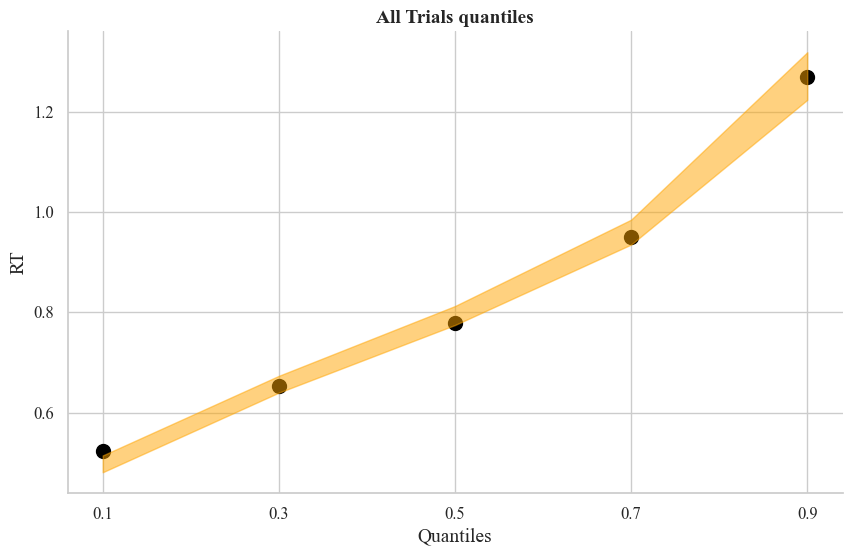

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

ax.set_title('All Trials quantiles', fontweight="bold", size=14)
ax.scatter(quantiles, all_quantiles_ex, color='black', s=100)

ax.fill_between(quantiles,
                all_predicted_bci[:, 0],
                all_predicted_bci[:, 1],
                all_predicted_bci[:, 0] < all_predicted_bci[:, 1],  color = 'orange', alpha=0.5)

ax.set_xlabel('Quantiles', fontsize=14)
ax.set_xticks(quantiles)
ax.set_xticklabels(quantiles)
ax.set_ylabel('RT', fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials.pdf')

### All Trials (word response vs non-word response)

In [41]:
exp_word_resp_all, pred_word_resp_all = GetDfs(response=1)
exp_nonword_resp_all, pred_nonword_resp_all = GetDfs(response=0)

In [42]:
word_quantiles_ex = exp_word_resp_all['rt'].quantile(quantiles)
nonword_quantiles_ex = exp_nonword_resp_all['rt'].quantile(quantiles)

word_quantiles_pred = pred_word_resp_all.quantile(quantiles, axis=1).T
nonword_quantiles_pred = pred_nonword_resp_all.quantile(quantiles, axis=1).T

word_predicted_bci = np.array([bci(word_quantiles_pred[x]) for x in quantiles])
nonword_predicted_bci = np.array([bci(nonword_quantiles_pred[x]) for x in quantiles])

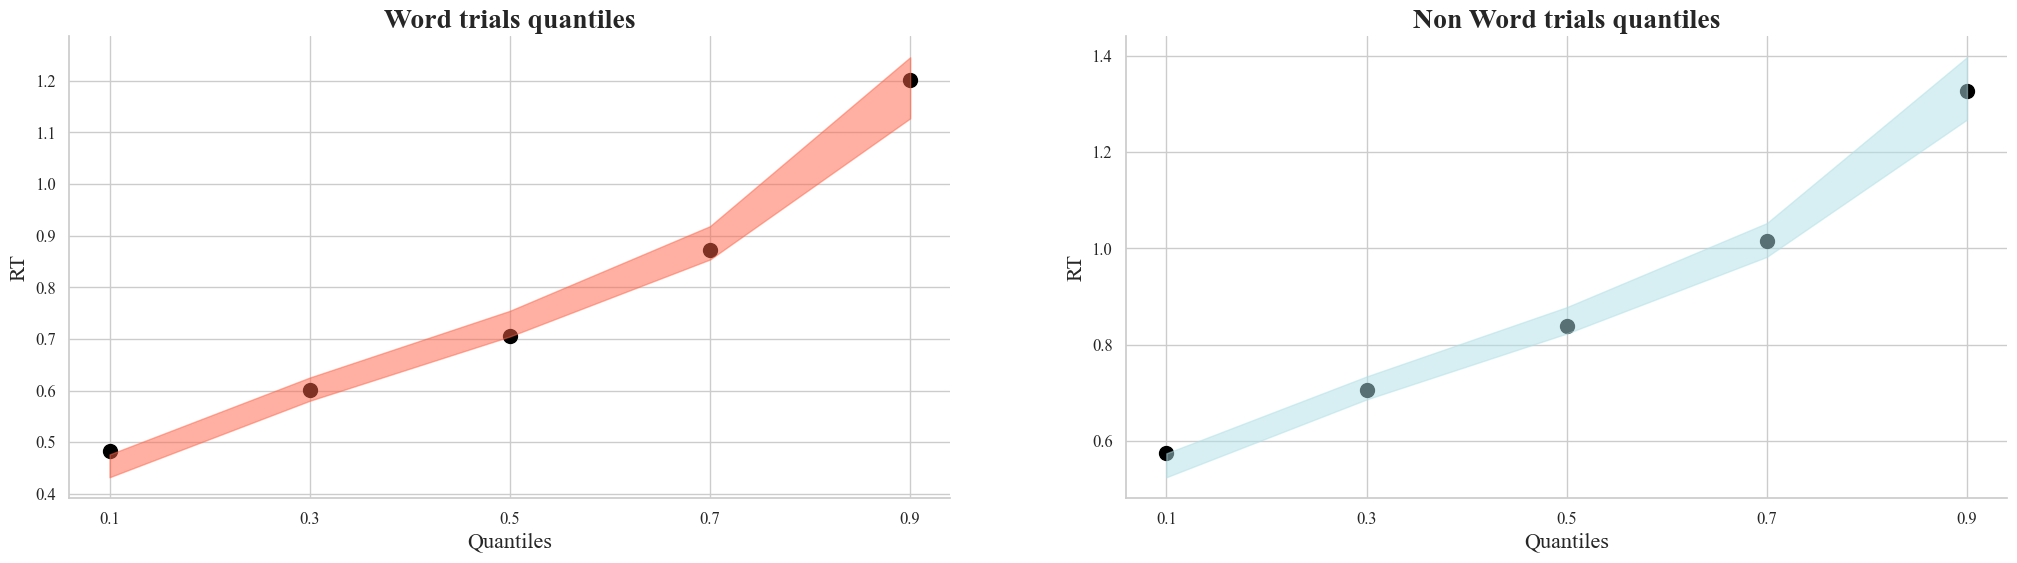

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('Word trials quantiles', fontweight="bold", size=20)
axes[1].set_title('Non Word trials quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, word_quantiles_ex, color='black', s=100)
axes[1].scatter(quantiles, nonword_quantiles_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                word_predicted_bci[:, 0],
                word_predicted_bci[:, 1],
                word_predicted_bci[:, 0] < word_predicted_bci[:, 1],  color = 'tomato', alpha=0.5)

axes[1].fill_between(quantiles,
                nonword_predicted_bci[:, 0],
                nonword_predicted_bci[:, 1],
                nonword_predicted_bci[:, 0] < nonword_predicted_bci[:, 1],  color = 'powderblue', alpha=0.5)

for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=16)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RT', fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials-Word vs Nonword.pdf')

### All trials (Correct Choice vs Incorrect Choice) 

In [44]:
exp_cor_choice_all, _ = GetDfs(accuracy=1)
exp_incor_resp_all, _ = GetDfs(accuracy=0)
pred_cor_choice_all = predictedData['rt'][predictedData['response']==behavioural_df['label']]
pred_incor_choice_all = predictedData['rt'][predictedData['response']!=behavioural_df['label']]

In [45]:
cor_quantiles_ex = exp_cor_choice_all['rt'].quantile(quantiles)
incor_quantiles_ex = exp_incor_resp_all['rt'].quantile(quantiles)

cor_quantiles_pred = pred_cor_choice_all.quantile(quantiles, axis=1).T
incor_quantiles_pred = pred_incor_choice_all.quantile(quantiles, axis=1).T

cor_predicted_bci = np.array([bci(cor_quantiles_pred[x]) for x in quantiles])
incor_predicted_bci = np.array([bci(incor_quantiles_pred[x]) for x in quantiles])

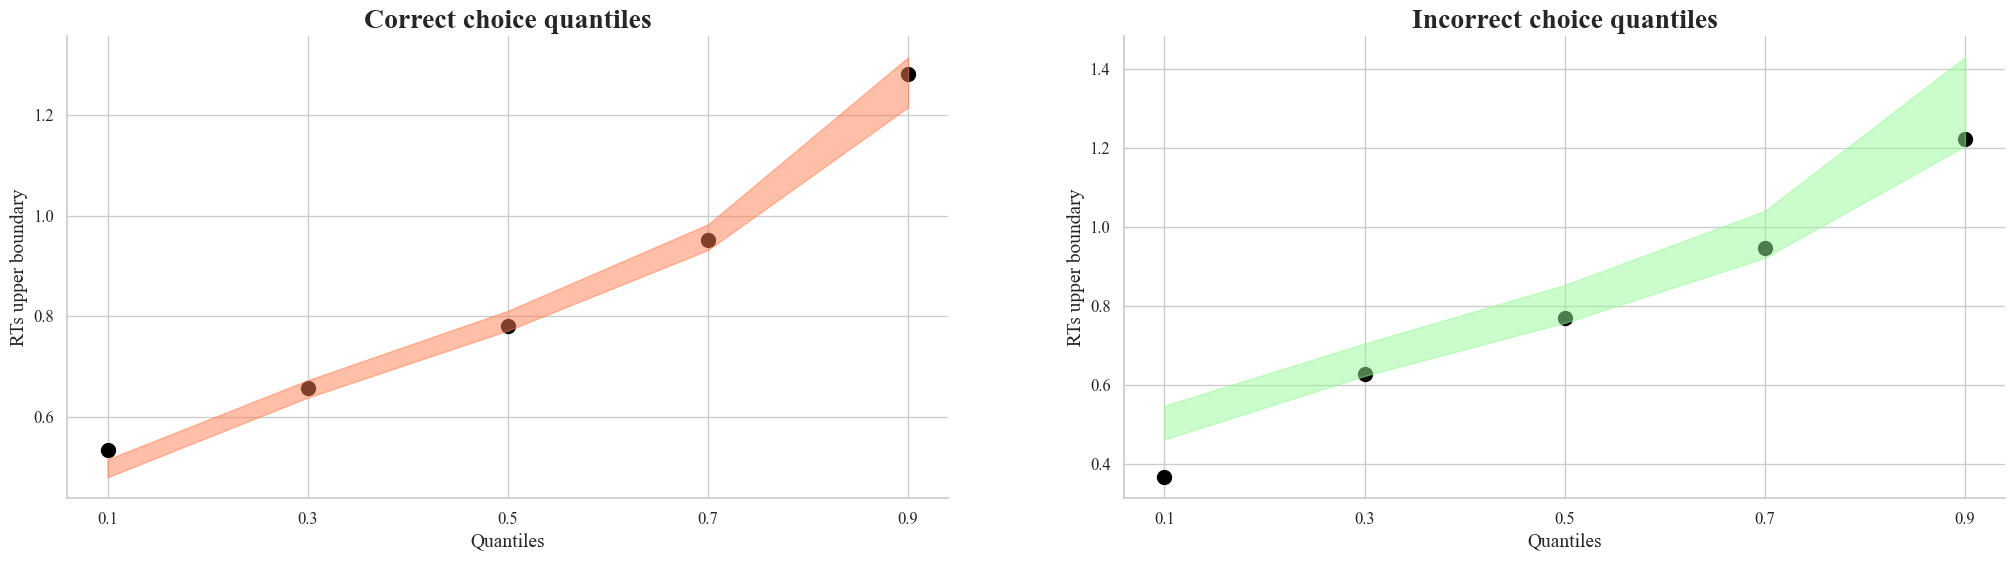

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('Correct choice quantiles', fontweight="bold", size=20)
axes[1].set_title('Incorrect choice quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, cor_quantiles_ex, color='black', s=100)
axes[1].scatter(quantiles, incor_quantiles_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                cor_predicted_bci[:, 0],
                cor_predicted_bci[:, 1],
                cor_predicted_bci[:, 0] < cor_predicted_bci[:, 1],  color = 'coral', alpha=0.5)

axes[1].fill_between(quantiles,
                incor_predicted_bci[:, 0],
                incor_predicted_bci[:, 1],
                incor_predicted_bci[:, 0] < incor_predicted_bci[:, 1],  color = 'palegreen', alpha=0.5)

for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=14)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials-Correct vs Incorrect.pdf')

### Conditional (HF, LF, NW trials)

In [47]:
exp_HF_trials, pred_HF_trials = GetDfs(category="HF")
exp_LF_trials, pred_LF_trials = GetDfs(category="LF")
exp_NW_trials, pred_NW_trials = GetDfs(category="NW")

In [48]:
# experiment Data quantile
HF_quantile_ex = exp_HF_trials['rt'].quantile(quantiles)
LF_quantile_ex = exp_LF_trials['rt'].quantile(quantiles)
NW_quantile_ex = exp_NW_trials['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

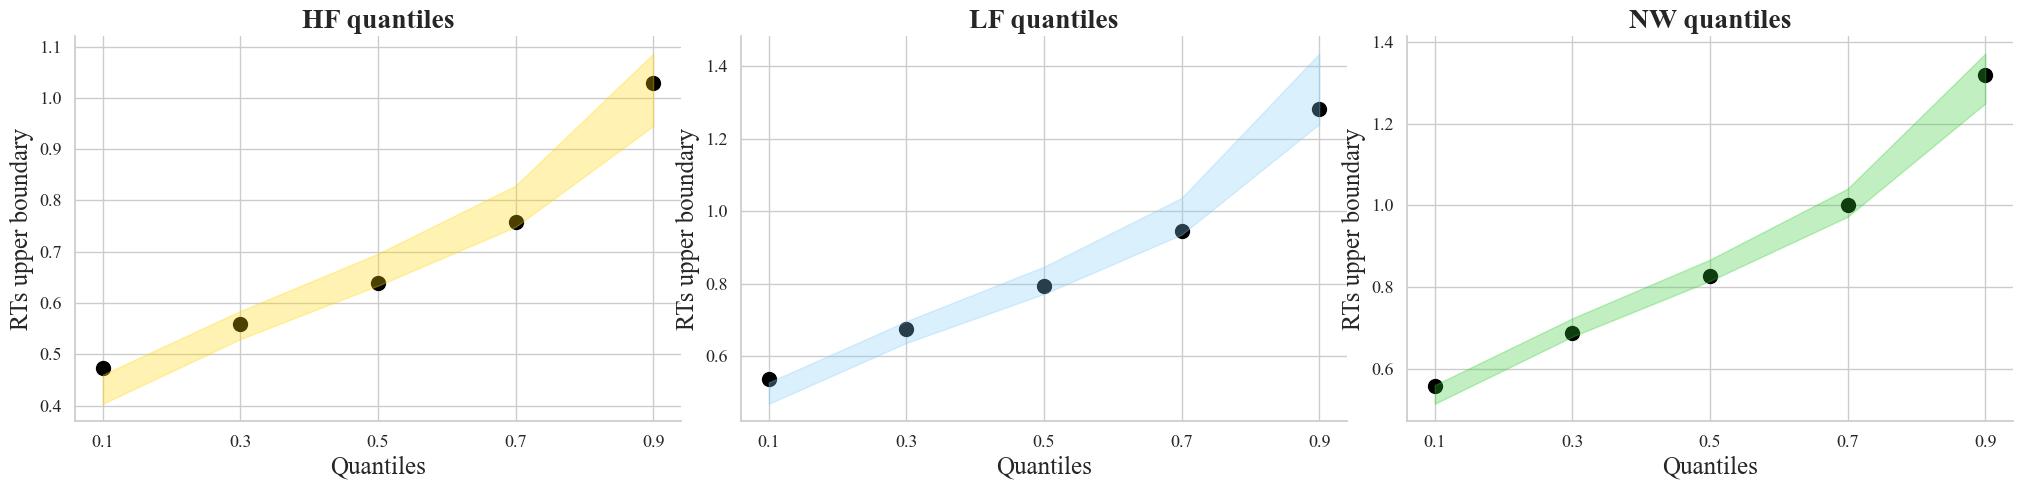

In [49]:
fig, axes = plt.subplots(1,3 , figsize=(25,5))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-Conditional.pdf')

### Conditional (HF, LF, NW trials) for word response and nonword response

In [50]:
exp_word_resp_HF, pred_word_resp_HF = GetDfs(category="HF", response=1)
exp_word_resp_LF, pred_word_resp_LF = GetDfs(category="LF", response=1)
exp_word_resp_NW, pred_word_resp_NW = GetDfs(category="NW", response=1)

exp_nonword_resp_HF, pred_nonword_resp_HF = GetDfs(category="HF", response=0)
exp_nonword_resp_LF, pred_nonword_resp_LF = GetDfs(category="LF", response=0)
exp_nonword_resp_NW, pred_nonword_resp_NW = GetDfs(category="NW", response=0)

In [51]:
# experiment Data quantile
HF_word_quantile_ex = exp_word_resp_HF['rt'].quantile(quantiles)
LF_word_quantile_ex = exp_word_resp_LF['rt'].quantile(quantiles)
NW_word_quantile_ex = exp_word_resp_NW['rt'].quantile(quantiles)

HF_nonword_quantile_ex = exp_nonword_resp_HF['rt'].quantile(quantiles)
LF_nonword_quantile_ex = exp_nonword_resp_LF['rt'].quantile(quantiles)
NW_nonword_quantile_ex = exp_nonword_resp_NW['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_word_quantile_pred = pred_word_resp_HF.quantile(quantiles, axis=1).T
LF_word_quantile_pred = pred_word_resp_LF.quantile(quantiles, axis=1).T
NW_word_quantile_pred = pred_word_resp_NW.quantile(quantiles, axis=1).T

HF_nonword_quantile_pred = pred_nonword_resp_HF.quantile(quantiles, axis=1).T
LF_nonword_quantile_pred = pred_nonword_resp_LF.quantile(quantiles, axis=1).T
NW_nonword_quantile_pred = pred_nonword_resp_NW.quantile(quantiles, axis=1).T


# predicted data quantiles bci
HF_word_predicted_bci = np.array([bci(HF_word_quantile_pred[x]) for x in quantiles])
LF_word_predicted_bci = np.array([bci(LF_word_quantile_pred[x]) for x in quantiles])
NW_word_predicted_bci = np.array([bci(NW_word_quantile_pred[x]) for x in quantiles])

HF_nonword_predicted_bci = np.array([bci(HF_nonword_quantile_pred[x]) for x in quantiles])
LF_nonword_predicted_bci = np.array([bci(LF_nonword_quantile_pred[x]) for x in quantiles])
NW_nonword_predicted_bci = np.array([bci(NW_nonword_quantile_pred[x]) for x in quantiles])

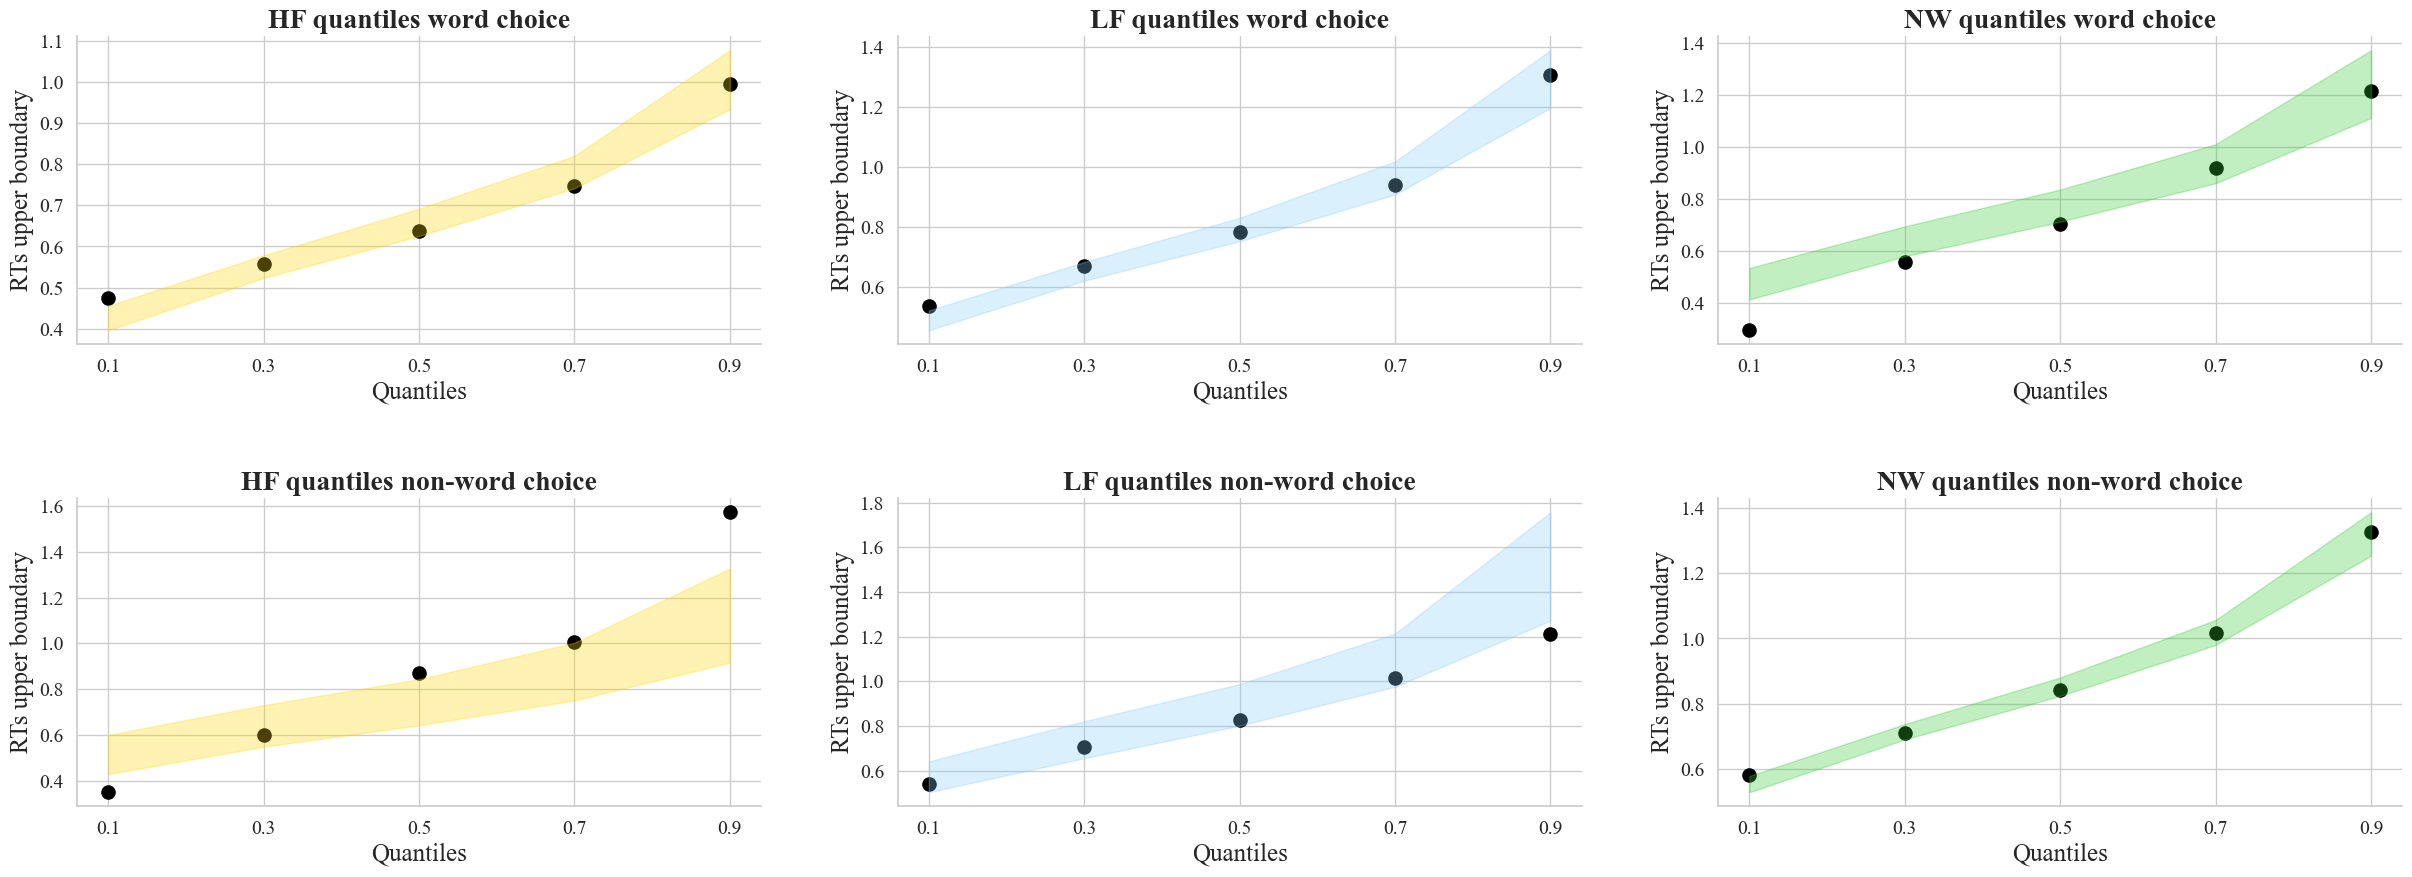

In [52]:
fig, axes = plt.subplots(2,3 , figsize=(30,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0][0].set_title('HF quantiles word choice', fontweight="bold", size=20)
axes[0][1].set_title('LF quantiles word choice', fontweight="bold", size=20)
axes[0][2].set_title('NW quantiles word choice', fontweight="bold", size=20)

axes[1][0].set_title('HF quantiles non-word choice', fontweight="bold", size=20)
axes[1][1].set_title('LF quantiles non-word choice', fontweight="bold", size=20)
axes[1][2].set_title('NW quantiles non-word choice', fontweight="bold", size=20)

axes[0][0].scatter(quantiles, HF_word_quantile_ex, color='black', s=90)
axes[0][1].scatter(quantiles, LF_word_quantile_ex, color='black', s=90)
axes[0][2].scatter(quantiles, NW_word_quantile_ex, color='black', s=90)

axes[1][0].scatter(quantiles, HF_nonword_quantile_ex, color='black', s=90)
axes[1][1].scatter(quantiles, LF_nonword_quantile_ex, color='black', s=90)
axes[1][2].scatter(quantiles, NW_nonword_quantile_ex, color='black', s=90)


axes[0][0].fill_between(quantiles,
                HF_word_predicted_bci[:, 0],
                HF_word_predicted_bci[:, 1],
                HF_word_predicted_bci[:, 0] < HF_word_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[0][1].fill_between(quantiles,
                LF_word_predicted_bci[:, 0],
                LF_word_predicted_bci[:, 1],
                LF_word_predicted_bci[:, 0] < LF_word_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[0][2].fill_between(quantiles,
                NW_word_predicted_bci[:, 0],
                NW_word_predicted_bci[:, 1],
                NW_word_predicted_bci[:, 0] < NW_word_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


axes[1][0].fill_between(quantiles,
                HF_nonword_predicted_bci[:, 0],
                HF_nonword_predicted_bci[:, 1],
                HF_nonword_predicted_bci[:, 0] < HF_nonword_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1][1].fill_between(quantiles,
                LF_nonword_predicted_bci[:, 0],
                LF_nonword_predicted_bci[:, 1],
                LF_nonword_predicted_bci[:, 0] < LF_nonword_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[1][2].fill_between(quantiles,
                NW_nonword_predicted_bci[:, 0],
                NW_nonword_predicted_bci[:, 1],
                NW_nonword_predicted_bci[:, 0] < NW_nonword_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax_d1 in axes:
    for ax in ax_d1:
        ax.set_xlabel('Quantiles', fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-Conditional-Word vs Nonword.pdf')

## Mean Accuracy and RT Posterior Prediction Checks


In [53]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

### All trials

In [54]:
exp_all_trials_rt, pred_all_trials_rt = GetDfs()
exp_all_trials_resp, pred_all_trials_resp = GetDfs(pred_df_type='response')

In [55]:
all_data_rt_mean = exp_all_trials_rt['rt'].mean()
all_pred_rt_mean = pred_all_trials_rt.mean(axis=1)

all_data_resp_mean = exp_all_trials_resp['response'].mean()
all_pred_resp_mean = pred_all_trials_resp.mean(axis=1)

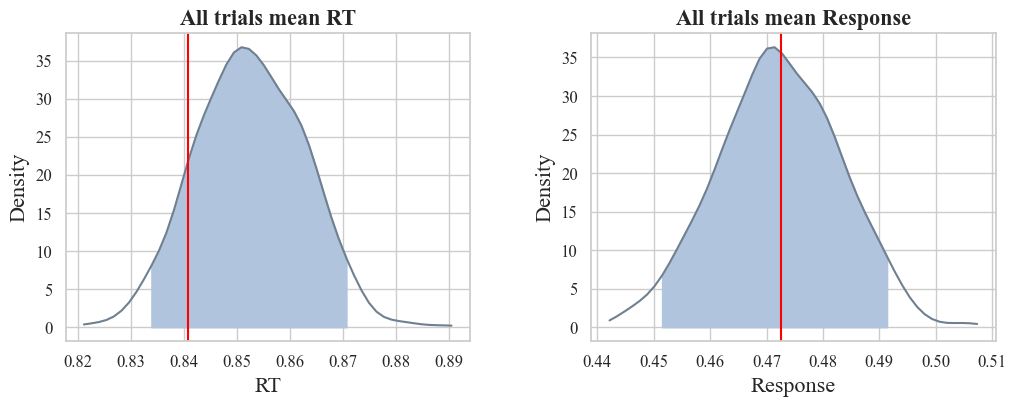

In [56]:
fig, axes = plt.subplots(1,2 , figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0].set_title('All trials mean RT', fontweight="bold", size=16)
axes[1].set_title('All trials mean Response', fontweight="bold", size=16)

plot_posterior(all_pred_rt_mean, all_data_rt_mean, axes[0])
plot_posterior(all_pred_resp_mean, all_data_resp_mean, axes[1])

axes[0].set_xlabel('RT', fontsize=16)
axes[1].set_xlabel('Response', fontsize=16)

for ax in axes:
        ax.set_ylabel('Density', fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
            
plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-All trials.pdf')

### All Trials (correct choice vs incorrect choice)

In [57]:
exp_cor_all_trials_rt, pred_cor_all_trials_rt = GetDfs(accuracy=1)
exp_incor_all_trials_rt, pred_incor_all_trials_rt = GetDfs(accuracy=0)

exp_cor_all_trials_resp, pred_cor_all_trials_resp = GetDfs(accuracy=1,
                                                             pred_df_type='response')
exp_incor_all_trials_resp, pred_incor_all_trials_resp = GetDfs(accuracy=0,
                                                             pred_df_type='response')

In [58]:
all_trials_cor_rt_mean = exp_cor_all_trials_rt['rt'].mean()
all_pred_cor_rt_mean = pred_cor_all_trials_rt.mean(axis=1)

all_trials_incor_rt_mean = exp_incor_all_trials_rt['rt'].mean()
all_pred_incor_rt_mean = pred_incor_all_trials_rt.mean(axis=1)


all_data_cor_resp_mean = exp_cor_all_trials_resp['response'].mean()
all_pred_cor_resp_mean = pred_cor_all_trials_resp.mean(axis=1)

all_data_incor_resp_mean = exp_incor_all_trials_resp['response'].mean()
all_pred_incor_resp_mean = pred_incor_all_trials_resp.mean(axis=1)

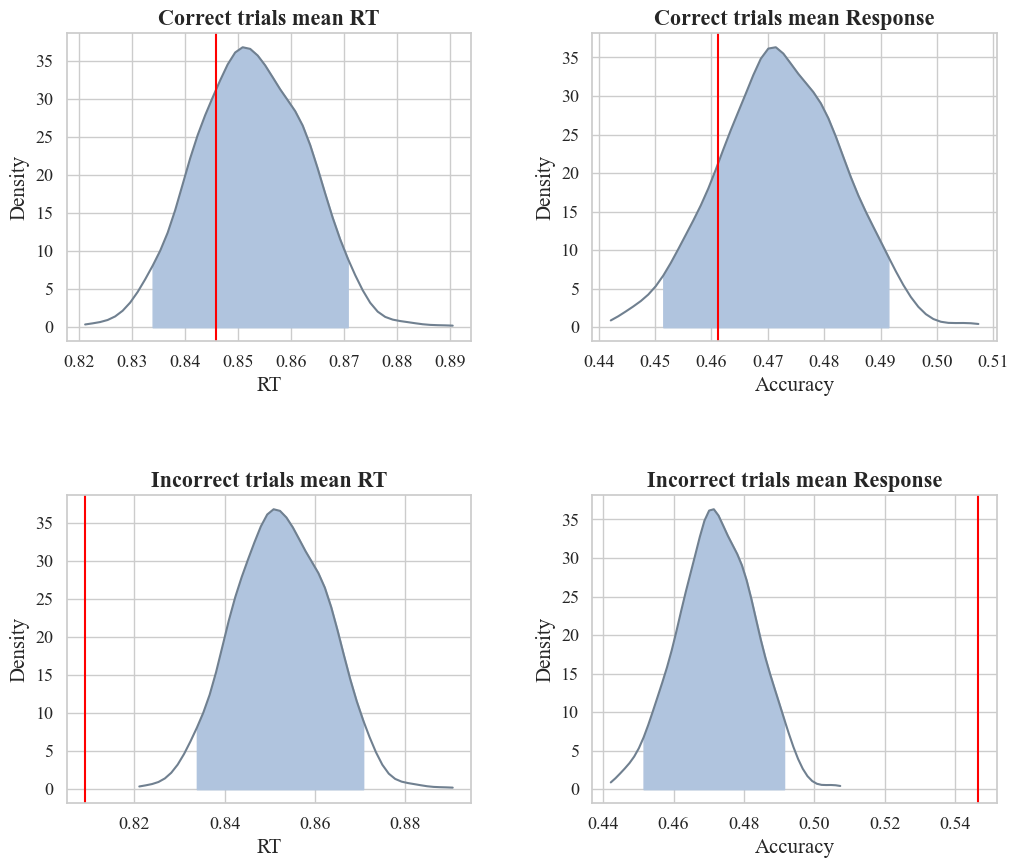

In [59]:
fig, axes = plt.subplots(2,2 , figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('Correct trials mean RT', fontweight="bold", size=16)
axes[0][1].set_title('Correct trials mean Response', fontweight="bold", size=16)
axes[1][0].set_title('Incorrect trials mean RT', fontweight="bold", size=16)
axes[1][1].set_title('Incorrect trials mean Response', fontweight="bold", size=16)

plot_posterior(all_pred_cor_rt_mean, all_trials_cor_rt_mean, axes[0][0])
plot_posterior(all_pred_cor_resp_mean, all_data_cor_resp_mean, axes[0][1])

plot_posterior(all_pred_incor_rt_mean, all_trials_incor_rt_mean, axes[1][0])
plot_posterior(all_pred_incor_resp_mean, all_data_incor_resp_mean, axes[1][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-All trials-Correct vs Incorrect.pdf')

### Conditional (HF, LF, NW trials) 

In [60]:
exp_HF_trials_rt, pred_HF_trials_rt = GetDfs(category="HF")
exp_LF_trials_rt, pred_LF_trials_rt = GetDfs(category="LF")
exp_NW_trials_rt, pred_NW_trials_rt = GetDfs(category="NW")

exp_HF_trials_resp, pred_HF_trials_resp = GetDfs(category="HF", pred_df_type='response')
exp_LF_trials_resp, pred_LF_trials_resp = GetDfs(category="LF", pred_df_type='response')
exp_NW_trials_resp, pred_NW_trials_resp = GetDfs(category="NW", pred_df_type='response')

In [61]:
HF_data_rt_mean = exp_HF_trials_rt['rt'].mean()
LF_data_rt_mean = exp_LF_trials_rt['rt'].mean()
NW_data_rt_mean = exp_NW_trials_rt['rt'].mean()

HF_pred_rt_mean = pred_HF_trials_rt.mean(axis=1)
LF_pred_rt_mean = pred_LF_trials_rt.mean(axis=1)
NW_pred_rt_mean = pred_NW_trials_rt.mean(axis=1)


HF_data_resp_mean = exp_HF_trials_resp['response'].mean()
LF_data_resp_mean = exp_LF_trials_resp['response'].mean()
NW_data_resp_mean = exp_NW_trials_resp['response'].mean()

HF_pred_resp_mean = pred_HF_trials_resp.mean(axis=1)
LF_pred_resp_mean = pred_LF_trials_resp.mean(axis=1)
NW_pred_resp_mean = pred_NW_trials_resp.mean(axis=1)


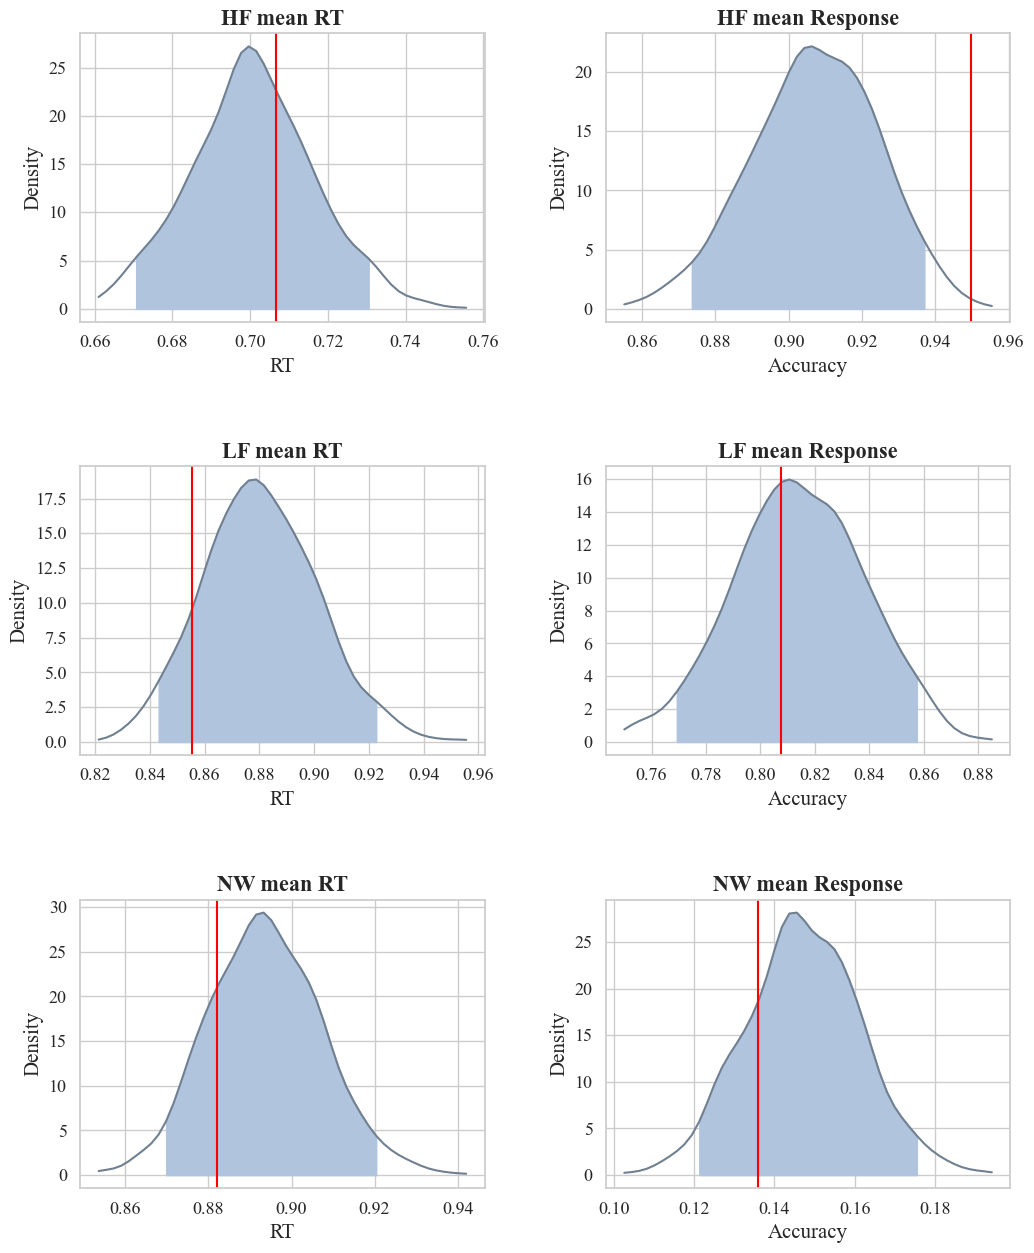

In [62]:
fig, axes = plt.subplots(3,2 , figsize=(12,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-Conditional.pdf')